In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model


Found 2819 images belonging to 8 classes.
188/188 [==============================] - 37s 189ms/step


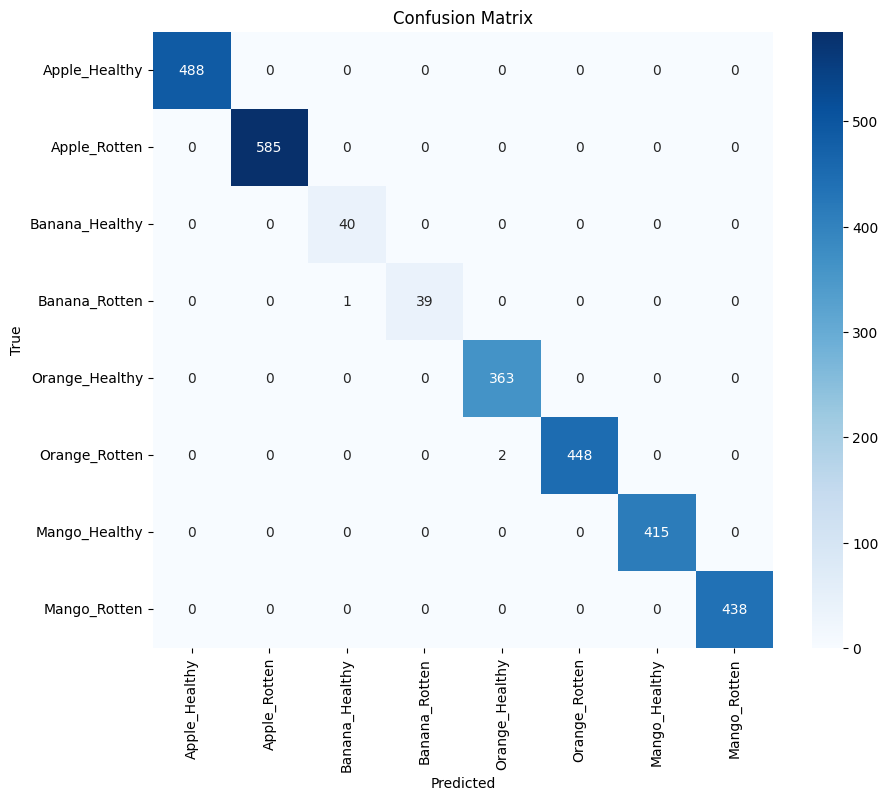

Overall Accuracy: 1.00

Classification Report:
                 precision    recall  f1-score   support

 Apple_Healthy       1.00      1.00      1.00       488
  Apple_Rotten       1.00      1.00      1.00       585
Banana_Healthy       0.98      1.00      0.99        40
 Banana_Rotten       1.00      0.97      0.99        40
Orange_Healthy       0.99      1.00      1.00       363
 Orange_Rotten       1.00      1.00      1.00       450
 Mango_Healthy       1.00      1.00      1.00       415
  Mango_Rotten       1.00      1.00      1.00       438

      accuracy                           1.00      2819
     macro avg       1.00      1.00      1.00      2819
  weighted avg       1.00      1.00      1.00      2819


Apple_Healthy:
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00

Apple_Rotten:
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00

Banana_Healthy:
  Precision: 0.98
  Recall: 1.00
  F1-Score: 0.99

Banana_Rotten:
  Precision: 1.00
  Recall: 0.97
  F1-Score: 0.99

Orange_Healt

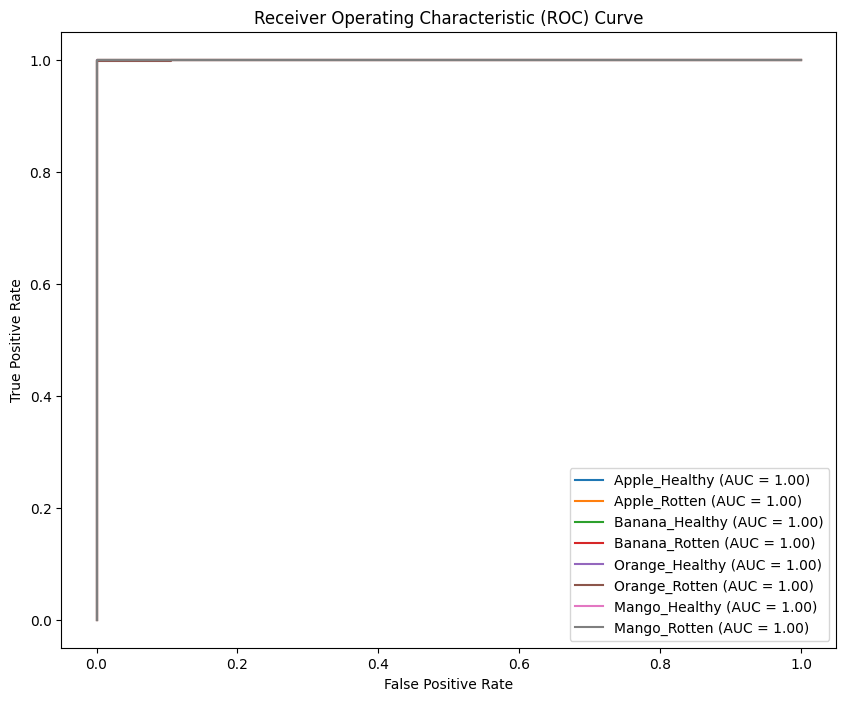


Overall AUC: 1.00


In [2]:

# Define disease types (labels)
disease_types = [

    'Apple_Healthy',
    'Apple_Rotten',
    'Banana_Healthy',
    'Banana_Rotten',
    'Orange_Healthy',
    'Orange_Rotten',
    'Mango_Healthy',
    'Mango_Rotten'

]

# Utility function to load saved model weights
def load_saved_model_weights(weights_path):
    input_shape = (128, 128, 3)
    inputs = Input(input_shape)
    efficient_net = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')(inputs)
    outputs = GlobalAveragePooling2D()(efficient_net)
    outputs = Dropout(0.25)(outputs)
    outputs = Dense(len(disease_types), activation='softmax')(outputs)
    model = Model(inputs, outputs)
    model.load_weights(weights_path)
    return model

# Function to generate confusion matrix and display metrics
def generate_confusion_matrix(model, test_dir, batch_size=15, target_size=(128, 128)):
    # Initialize the ImageDataGenerator to preprocess the images
    test_datagen = ImageDataGenerator()  # No rescaling here
    
    # Set up the generator to read images from the test directory
    test_generator = test_datagen.flow_from_directory(
        test_dir,  # Directory containing subdirectories for each class
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',  # Labels in categorical format
        shuffle=False  # Keep the order of the data for accuracy
    )

    # Get true labels (ground truth)
    true_labels = test_generator.classes
    class_labels = test_generator.class_indices
    class_labels = dict((v, k) for k, v in class_labels.items())  # Inverse mapping of indices to class names

    # Get predictions from the model
    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=disease_types, yticklabels=disease_types)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Calculate overall accuracy
    accuracy = np.trace(cm) / np.sum(cm)
    print(f"Overall Accuracy: {accuracy:.2f}")

    # Print detailed classification report (Precision, Recall, F1-Score)
    print("\nClassification Report:\n", classification_report(true_labels, predicted_labels, target_names=disease_types))
    
    # Precision, Recall, F1-Score for each class
    precision = precision_score(true_labels, predicted_labels, average=None)
    recall = recall_score(true_labels, predicted_labels, average=None)
    f1 = f1_score(true_labels, predicted_labels, average=None)
    
    # Display Precision, Recall, F1-Score for each class
    for i, disease in enumerate(disease_types):
        print(f"\n{disease}:")
        print(f"  Precision: {precision[i]:.2f}")
        print(f"  Recall: {recall[i]:.2f}")
        print(f"  F1-Score: {f1[i]:.2f}")
    
    # Calculate ROC curve and AUC for multi-class classification
    # One-hot encoding for true labels
    true_labels_one_hot = tf.keras.utils.to_categorical(true_labels, num_classes=len(disease_types))
    
    # Compute ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(disease_types)):
        fpr[i], tpr[i], _ = roc_curve(true_labels_one_hot[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    for i in range(len(disease_types)):
        plt.plot(fpr[i], tpr[i], label=f'{disease_types[i]} (AUC = {roc_auc[i]:.2f})')

    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Displaying overall AUC score
    print(f"\nOverall AUC: {np.mean(list(roc_auc.values())):.2f}")

# Example usage
if __name__ == "__main__":
    # Load the model
    model_path = 'Trained_Models/LastModel_weights.h5'  # Path to your model weights
    model = load_saved_model_weights(model_path)
    
    # Directory where your test images are stored (ensure the directory has subdirectories for each class)
    test_dir = 'datasets/val'  # Replace with the path to your test data
    
    # Generate confusion matrix and additional metrics
    generate_confusion_matrix(model, test_dir)
